# Hemoglobin Cooperation Project

### Plotting the Data

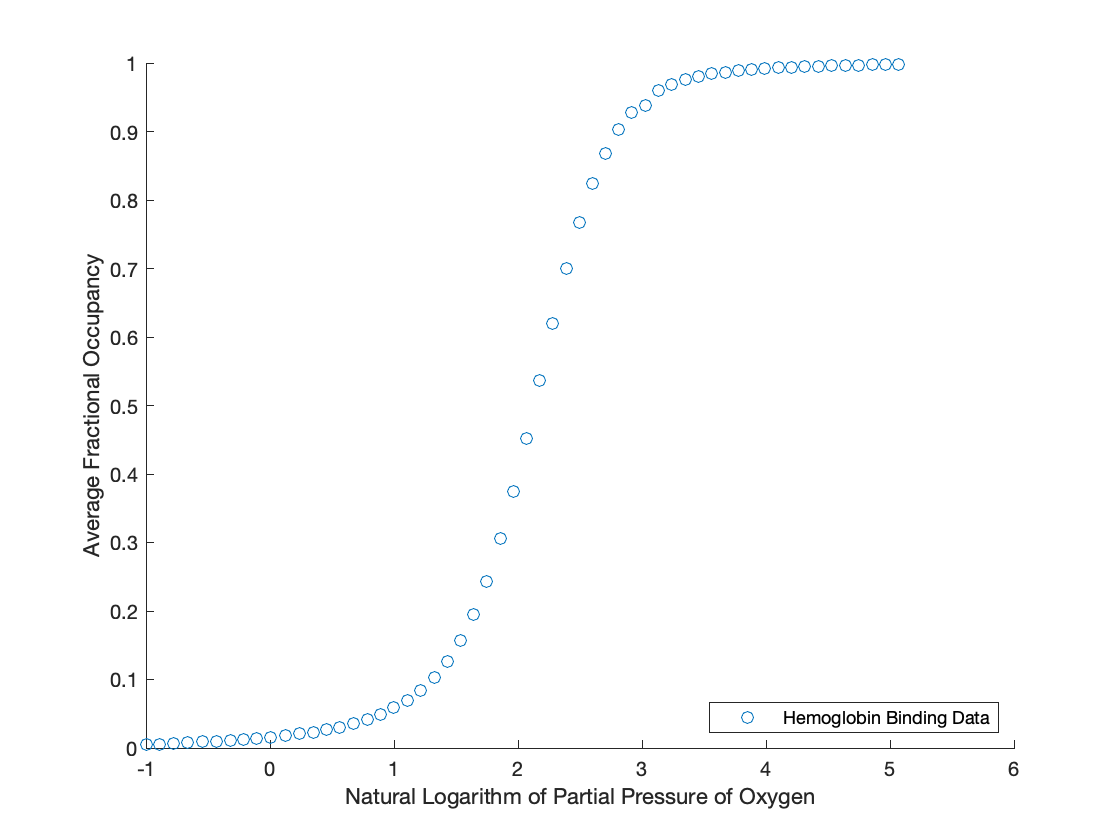

In [65]:
warning('off','all'); % turn off warnings %
table = readtable("Hemoglobin_Binding_Data.csv");
frac_occupancy = table.FractionalOccupancy;
ln_ppo2 = table.NaturalLogOfPartialPressure;
scatter(ln_ppo2, frac_occupancy)
legend({"Hemoglobin Binding Data"}, "location", "southeast")
xlabel("Natural Logarithm of Partial Pressure of Oxygen")
ylabel("Average Fractional Occupancy")

This is what our graph looks like of the average fractional occupancy vs the natural logarithm of the partial pressure of oxygen. We will attempt to fit our data by tuning some parameters using a couple Models.

**The Non-Cooperative Model:**

Energy of the system:

\begin{equation}
E = \varepsilon\sum_{\alpha=1}^{4} \sigma_{\alpha}
\end{equation}

Average predicted fractional occupancy:

\begin{equation}
\langle N\rangle = \frac{4x+ 12x^2 + 12x^3 + 4x^4}{1 + 4x+6x^2 + 4x^3 + x^4}
\end{equation}

**The Cooperative Model:**

Energy of the system:

\begin{equation}
E = \varepsilon\sum_{\alpha=1}^{4} \sigma_{\alpha} + \frac{J}{2} \sum_{(\alpha, \gamma)}' \sigma_{\alpha}\sigma_{\gamma}
\end{equation}

Average predicted fractional occupancy:

\begin{equation}
\langle N\rangle = \frac{4x+ 12x^2j + 12x^3j^3 + 4x^4j^6}{1 + 4x+6x^2j + 4x^3j^3 + x^4j^6}
\end{equation}



Let's see how these models differ.

### The Non-Cooperative Model

Let's assume the model is non-cooperative. Then we can use the following equation to predict the fractional occupancy. 

\begin{equation}
\langle N\rangle = \frac{4x+ 12x^2j + 12x^3j^3 + 4x^4j^6}{1 + 4x+6x^2j + 4x^3j^3 + x^4j^6}
\end{equation}

But since we're assuming non-cooperative, we assume `j=1`, so really the equation looks like:

\begin{equation}
\langle N\rangle = \frac{4x+ 12x^2 + 12x^3 + 4x^4}{1 + 4x+6x^2 + 4x^3 + x^4}
\end{equation}

First let's reverse the natural log of PPO2 to just PPO2. The reason for doing so will become apparent later. 

In [66]:
ppo2 = exp(ln_ppo2);

To fit `x`, we need to minimize the error of the data between the model. We can do this by introducing a fit parameter, `b`.

\begin{equation}
x = e^{ln(P_{O_{2}})}b = P_{O_{2}}b
\end{equation}

Let's try 1000 elements between \[0, 1) and look at the mean absolute error.

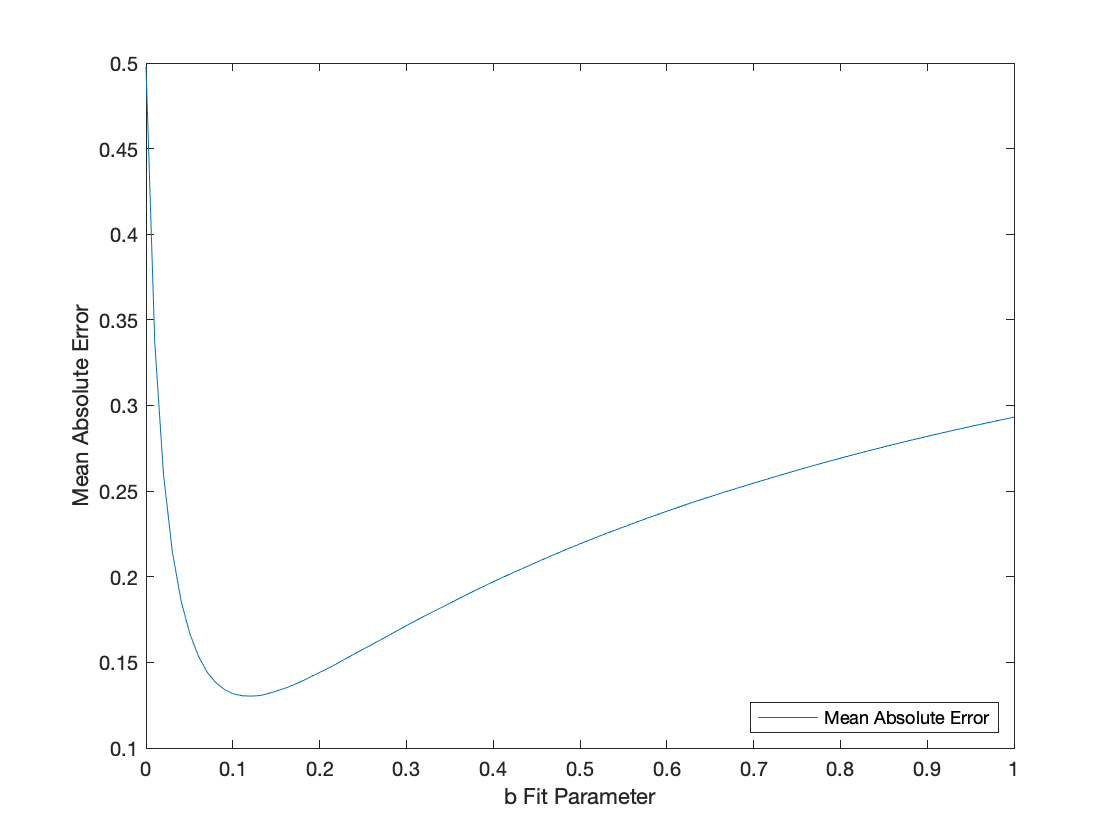

In [67]:
b = linspace(0, 1, 100);
x = ppo2.*b;
numerator = 4.*x+12.*x.^2+12.*x.^3+4.*x.^4;
denominator = 1+4.*x+6.*x.^2+4.*x.^3+x.^4;
N_hat = numerator ./ denominator ./ 4; 
error = sum(abs(N_hat - frac_occupancy)) ./ length(ln_ppo2);
plot(b, error)
legend({"Mean Absolute Error"}, "location", "southeast")
xlabel("b Fit Parameter")
ylabel("Mean Absolute Error")

We can use the `min` function to find the `b` with the lowest mean absolute error.

In [68]:
m = min(error)
b = b(find(error==m))

m = 
   0.1303

b = 
   0.1212

Using this `b`, we can use the above equation involving `x` and `<N>` to get the fit for the non-cooperative model.

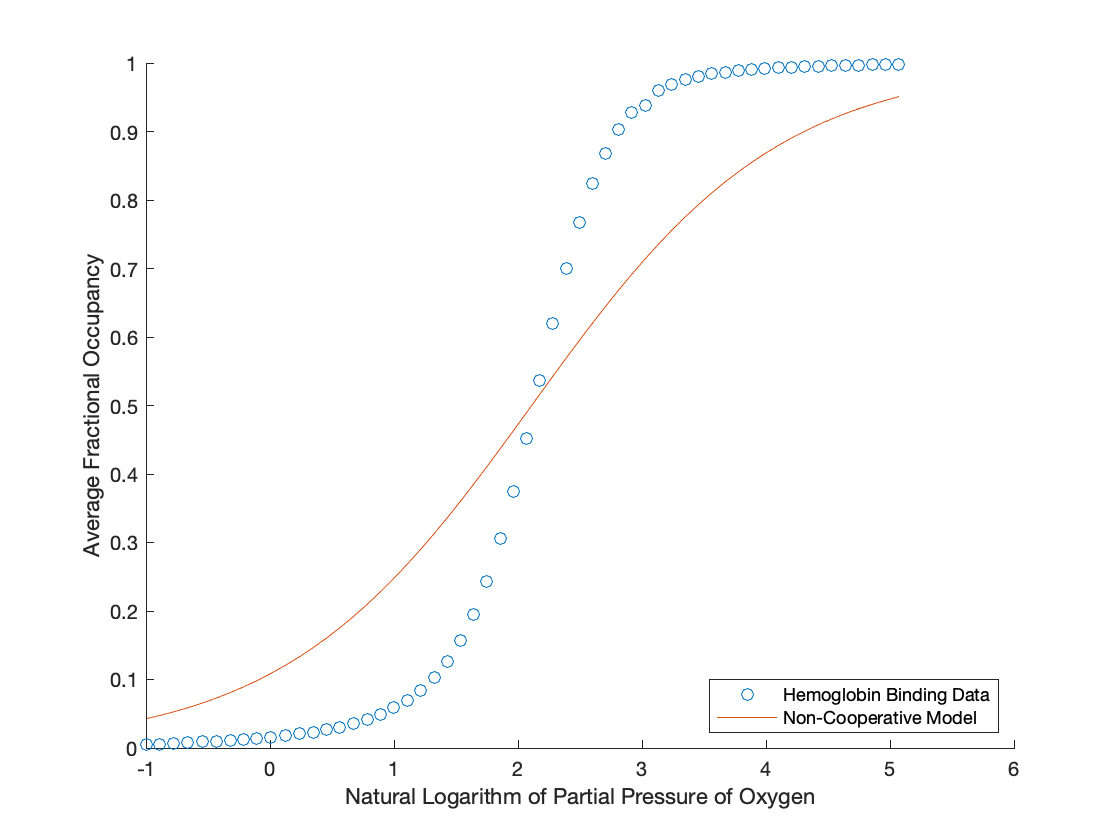

In [69]:
x = ppo2.*b;
numerator = 4.*x+12.*x.^2+12.*x.^3+4.*x.^4;
denominator = 1+4.*x+6.*x.^2+4.*x.^3+x.^4;
N = numerator ./ denominator ./ 4;
scatter(ln_ppo2, frac_occupancy)
hold on
plot(ln_ppo2, N)
hold off
legend({"Hemoglobin Binding Data", "Non-Cooperative Model"}, "location", "southeast")
xlabel("Natural Logarithm of Partial Pressure of Oxygen")
ylabel("Average Fractional Occupancy")

This fit doesn't appear right compared to the data.

### The Cooperative Model (Pauling)

Now let's check the cooperative model. This specific model is called the Pauling Model. In this case we must fit both parameters, and we cannot assume `j=1`.

\begin{equation}
\langle N\rangle = \frac{4x+ 12x^2j + 12x^3j^3 + 4x^4j^6}{1 + 4x+6x^2j + 4x^3j^3 + x^4j^6}
\end{equation}

Since we are fitting two parameters, we must work a little differently. Let's check many values of `b`, and cross check them with many values of `j`.

In [70]:
b = 0:.01:9.99;
j = 0:.01:9.99;
ppo2 = exp(ln_ppo2);
x = ppo2.*b;
N_hat_coop = [];
for k = 1:length(j)
    i = j(k);
    numerator = 4.*x+12.*(x.^2).*i+12.*(x.^3).*(i^3)+4.*(x.^4).*(i^6);
    denominator = 1+4.*x+6.*(x.^2).*i+4.*(x.^3).*(i^3)+x.^4.*(i^6);
    N_hat_coop(:,:,k) = numerator ./ denominator ./ 4; 
end

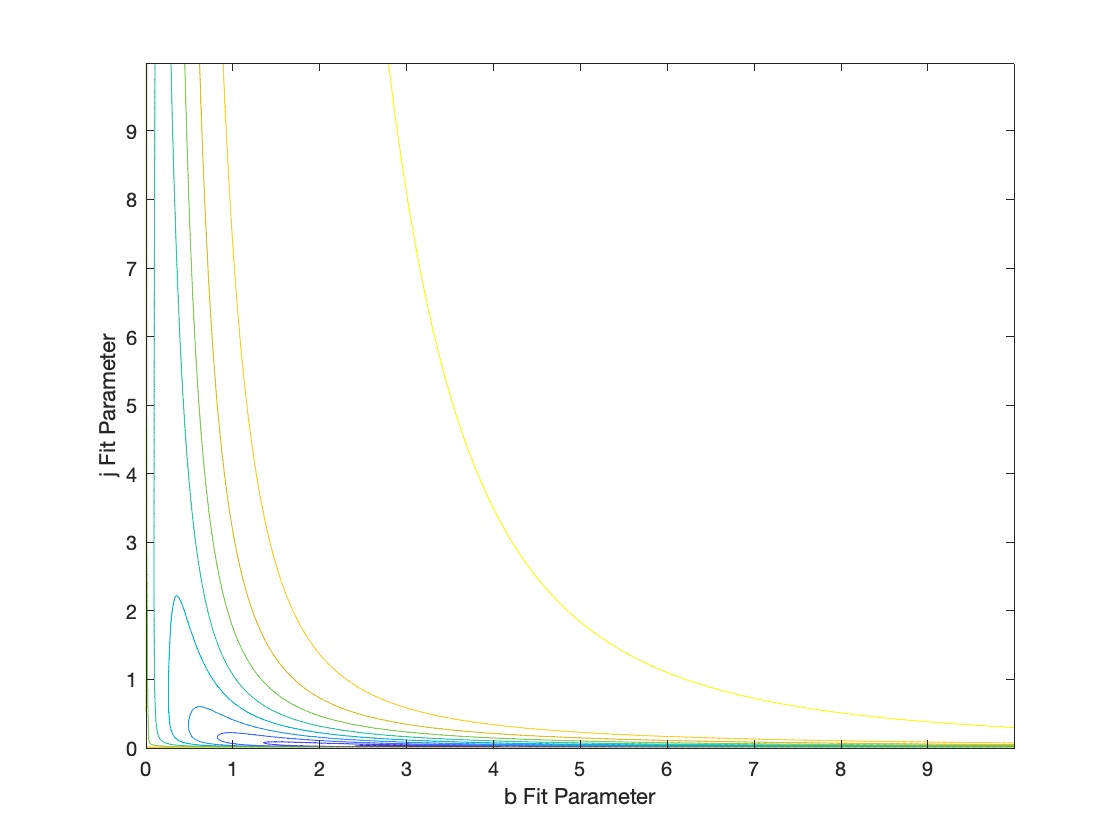

In [71]:
error = sum(abs(frac_occupancy - N_hat_coop(:,:,:))) ./ length(frac_occupancy);
error_T = reshape(error, length(b), length(j));
contour(b, j, error_T)
xlabel('b Fit Parameter')
ylabel('j Fit Parameter')

This contour plot shows us the mean absolute errors of different combinations of `b` and `j`. It seems that the error is minimized near the axes. It seems that the minimized error is when `j` is small, but that actually is not true. Upon closer inspection, the opposite is actually true, and the error is minimized when `b` is small (logical since most of the shape of the data comes from cooperation, which is `j`). Although not shown in this notebook, the specific range we want to inspect is a `j` of \[5,6\) and a `b` of \[0,0.1\).

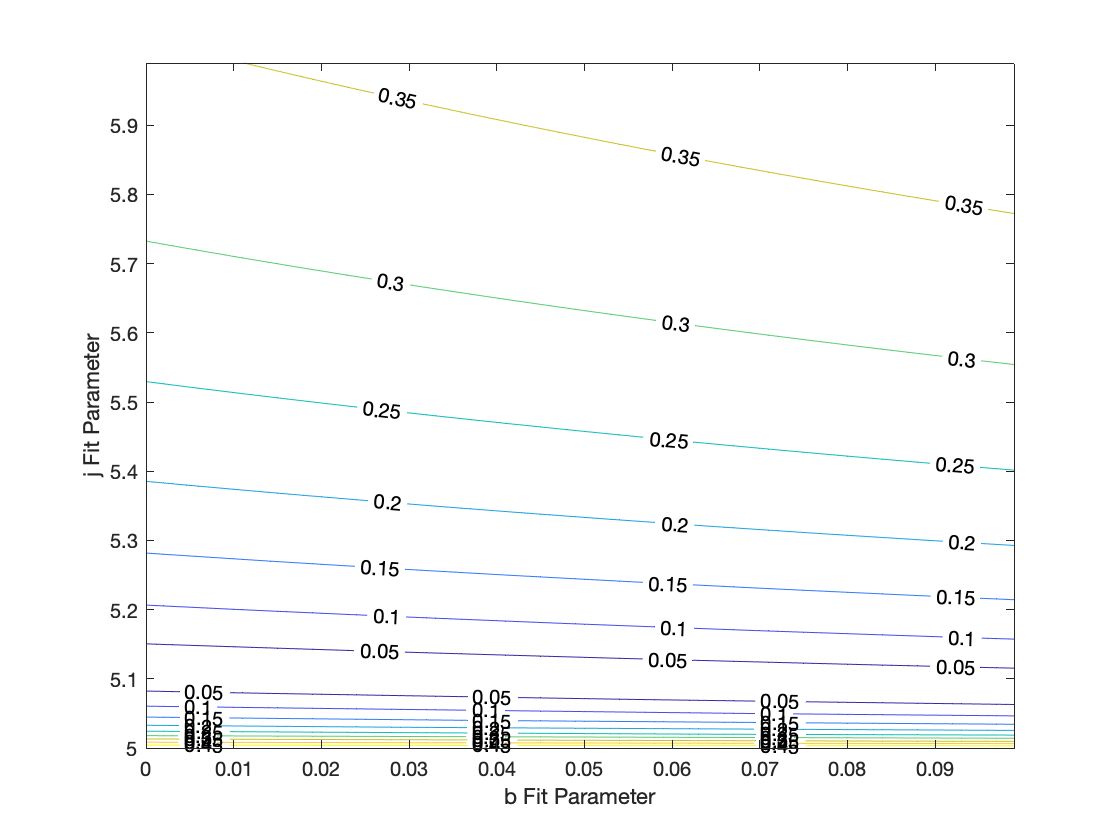

In [72]:
b = 0:.001:.099;
j = 5:.01:5.99;
ppo2 = exp(ln_ppo2);
x = ppo2.*b;
N_hat_coop = [];
for k = 1:length(j)
    i = j(k);
    numerator = 4.*x+12.*(x.^2).*i+12.*(x.^3).*(i^3)+4.*(x.^4).*(i^6);
    denominator = 1+4.*x+6.*(x.^2).*i+4.*(x.^3).*(i^3)+x.^4.*(i^6);
    N_hat_coop(:,:,k) = numerator ./ denominator ./ 4; 
end
error = sum(abs(frac_occupancy - N_hat_coop(:,:,:))) ./ length(frac_occupancy);
error_T = reshape(error, length(b), length(j));
contour(b, j, error_T, "ShowText", true)
xlabel('b Fit Parameter')
ylabel('j Fit Parameter')

Let's inspect the range of the `0.05` error a little closer.

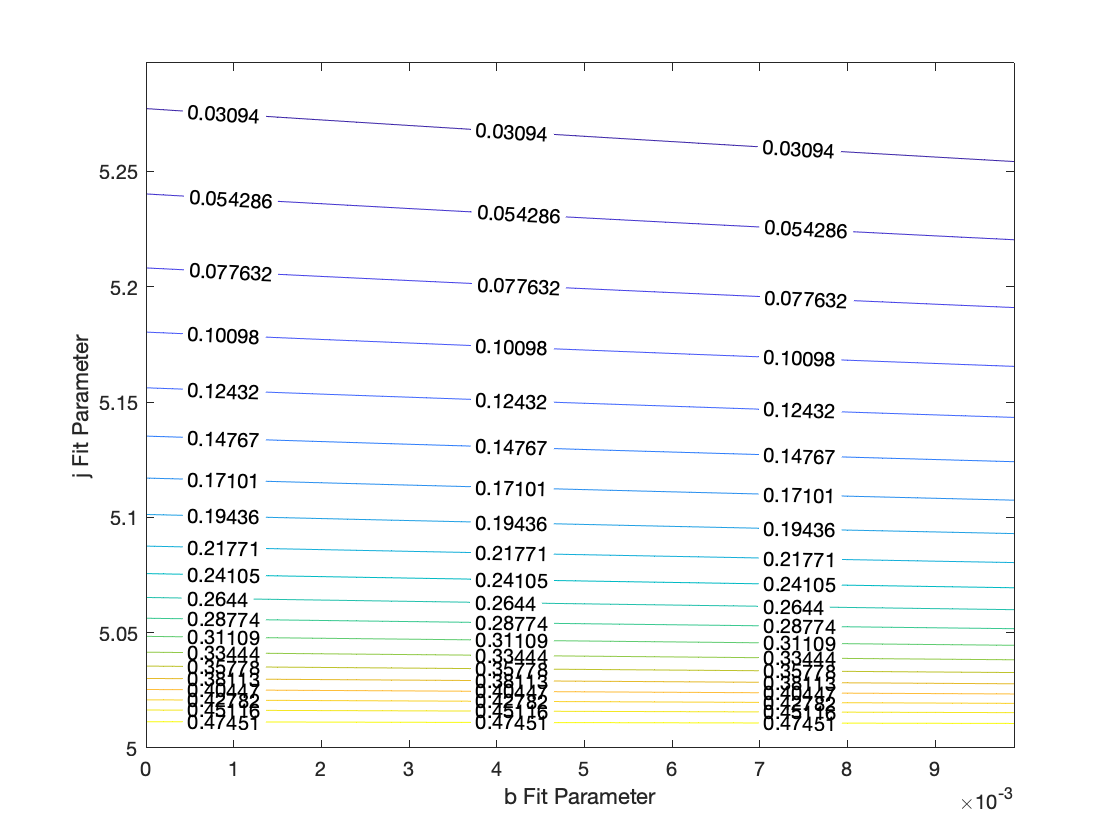

In [73]:
b = 0:.0001:.0099;
j = 5:.003:5.297;
ppo2 = exp(ln_ppo2);
x = ppo2.*b;
N_hat_coop = [];
for k = 1:length(j)
    i = j(k);
    numerator = 4.*x+12.*(x.^2).*i+12.*(x.^3).*(i^3)+4.*(x.^4).*(i^6);
    denominator = 1+4.*x+6.*(x.^2).*i+4.*(x.^3).*(i^3)+x.^4.*(i^6);
    N_hat_coop(:,:,k) = numerator ./ denominator ./ 4; 
end
error = sum(abs(frac_occupancy - N_hat_coop(:,:,:))) ./ length(frac_occupancy);
error_T = reshape(error, length(b), length(j));
contour(b, j, error_T, 20, "ShowText", true)
xlabel('b Fit Parameter')
ylabel('j Fit Parameter')

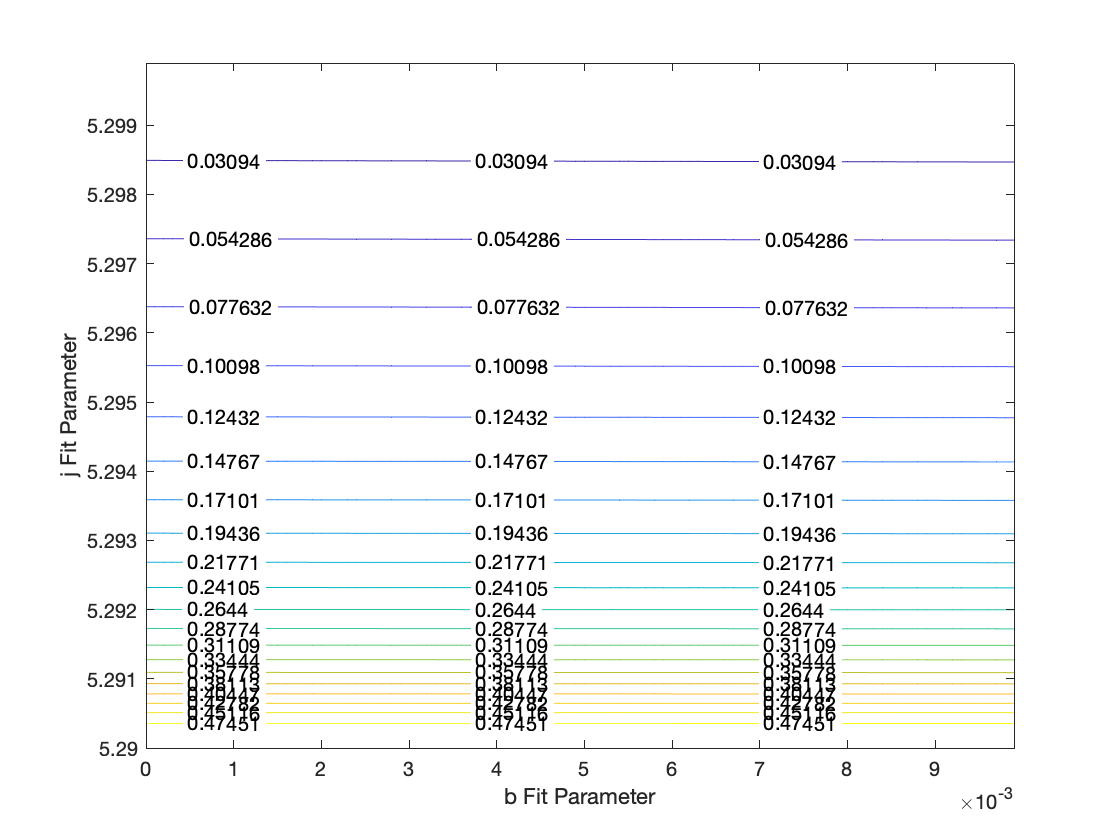

In [74]:
b = 0:.0001:.0099;
j = 5.29:.0001:5.29995;
ppo2 = exp(ln_ppo2);
x = ppo2.*b;
N_hat_coop = [];
for k = 1:length(j)
    i = j(k);
    numerator = 4.*x+12.*(x.^2).*i+12.*(x.^3).*(i^3)+4.*(x.^4).*(i^6);
    denominator = 1+4.*x+6.*(x.^2).*i+4.*(x.^3).*(i^3)+x.^4.*(i^6);
    N_hat_coop(:,:,k) = numerator ./ denominator ./ 4; 
end
error = sum(abs(frac_occupancy - N_hat_coop(:,:,:))) ./ length(frac_occupancy);
error_T = reshape(error, length(b), length(j));
contour(b, j, error_T, 20, "ShowText", true)
xlabel('b Fit Parameter')
ylabel('j Fit Parameter')

We can continue inspecting, but at this point let's choose a pair `(b, j)`. For simplicity, let's pick `b=0.01`, and then the corresponding `j=5.2985`. 

In [77]:
j = 5.2985
b = .01
ppo2 = exp(ln_ppo2);
x = ppo2.*b;
numerator = 4.*x+12.*(x.^2).*j+12.*(x.^3).*(j.^3)+4.*(x.^4).*(j.^6);
denominator = 1+4.*x+6.*(x.^2).*j+4.*(x.^3).*(j.^3)+x.^4.*(j.^6);
N_coop = numerator ./ denominator ./ 4;
lowest_error = sum(abs(frac_occupancy - N_coop)) ./ length(frac_occupancy)

j = 
   5.2985

b = 
   0.0100

lowest_error = 
   0.0077

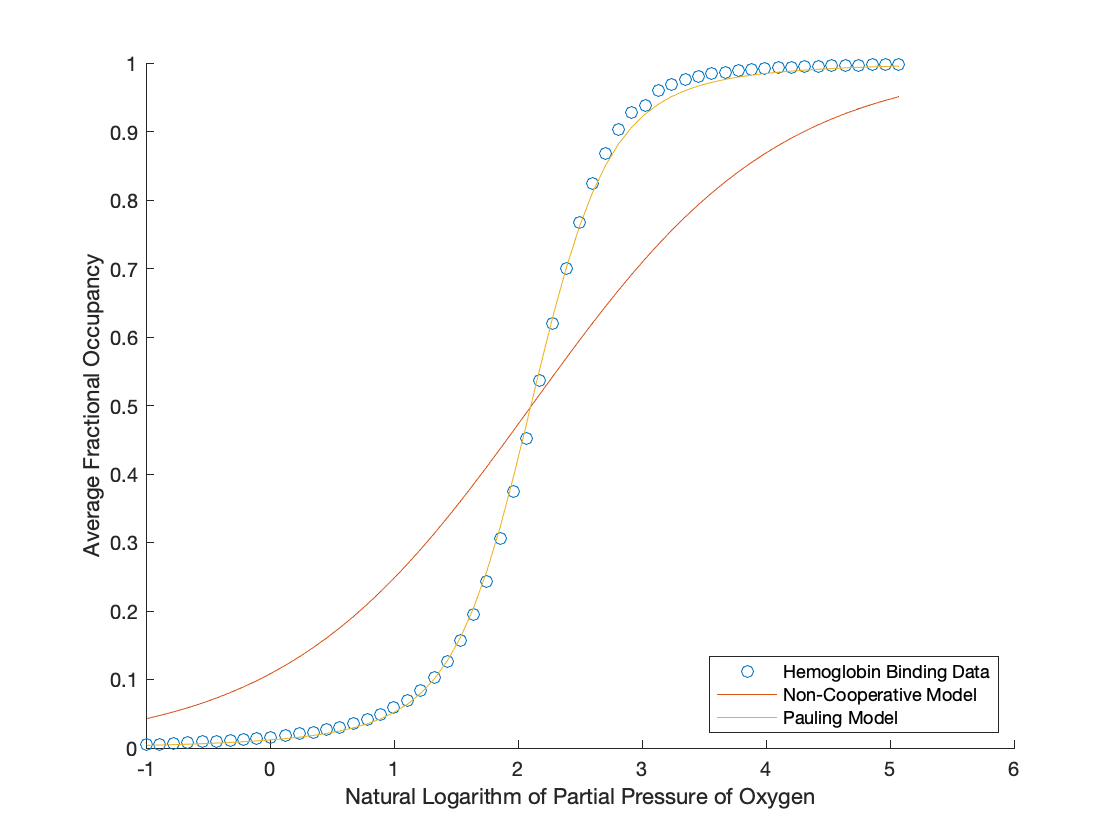

In [78]:
scatter(ln_ppo2, frac_occupancy)
hold on
plot(ln_ppo2, N)
plot(ln_ppo2, N_coop)
hold off
legend({"Hemoglobin Binding Data", "Non-Cooperative Model"}, "location", "southeast")
xlabel("Natural Logarithm of Partial Pressure of Oxygen")
ylabel("Average Fractional Occupancy")
legend({"Hemoglobin Binding Data", "Non-Cooperative Model", "Pauling Model"}, "location", "southeast")
xlabel("Natural Logarithm of Partial Pressure of Oxygen")
ylabel("Average Fractional Occupancy")

This model seems to already be much better than the non-cooperative model.